# Training Models for Butterfly Recognition

### Import Dependencies

In [1]:
# Dependencies
import os, os.path
import random
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

**Path to data**

In [80]:
images_path = "..\\leedsbutterfly\\images\\"
file = os.listdir(images_path)

**Get images and labels into lists**

In [81]:
images = []
labels = []

img_shape = (220, 220, 3)

for img in file:
    label = int(img[:3]) # First three digits will identify species (001, 002)
    labels.append(label)
    img_location = os.path.join(images_path, img)
    img_array = cv2.imread(img_location)[:,:,::-1] # Automatically converts from BGR to RGB
    img_array = cv2.resize(img_array, img_shape[:2])
    images.append(img_array)

**Set label for each picture**

In [82]:
dict_labels = {'001': 'Danaus_plexippus', 
               '002': 'Heliconius_charitonius', 
               '003': 'Heliconius_erato', 
               '004': 'Junonia_coenia', 
               '005': 'Lycaena_phlaeas', 
               '006': 'Nymphalis_antiopa', 
               '007': 'Papilio_cresphontes', 
               '008': 'Pieris_rapae', 
               '009': 'Vanessa_atalanta', 
               '0010': 'Vanessa_cardui'}

In [83]:
list_labels=[]
for i in labels:
    new_label=dict_labels['00'+str(i)]
    list_labels.append(new_label)

**Images to numpy array**

In [123]:
# Convert images list to np.array 
imgs_array = np.array(images)
imgs_array = imgs_array / 255.0
imgs_array.max(), imgs_array.shape

(1.0, (882, 220, 220, 3))

### Visualize images from the dataset

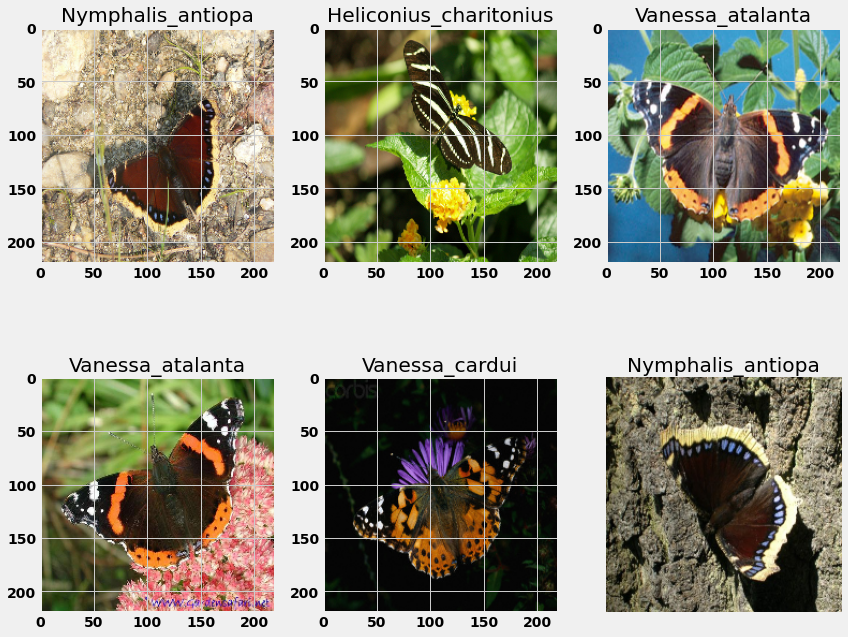

In [124]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(12,10)

for i in range(2):
    for j in range(3):
        rand_int = np.random.randint(0, len(labels))
        ax[i,j].imshow(imgs_array[rand_int])
        ax[i,j].set_title(str(list_labels[rand_int]))

plt.axis('off')
plt.tight_layout()

### Visualize image distribution within the dataset

C:\Users\danny\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


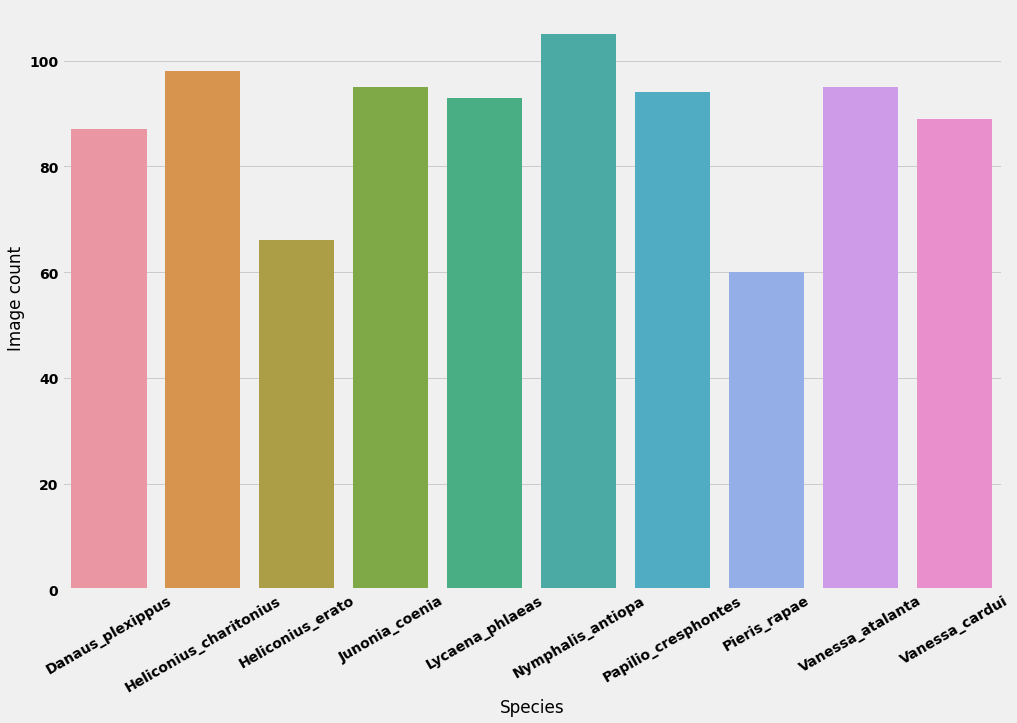

In [125]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))
fig=sns.countplot(list_labels)
plt.xlabel('Species')
plt.ylabel('Image count')
plt.xticks(rotation=30)
plt.show()

### One hot encoding

In [126]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [127]:
encoder = LabelEncoder()
Y = encoder.fit_transform(list_labels)
y = to_categorical(Y)
Y.shape, y.shape

((882,), (882, 10))

In [128]:
# Test a label
y[100]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Train/Test Split

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import tests

In [130]:
x_train,x_test,y_train,y_test = train_test_split(imgs_array, y, random_state=42, test_size=0.2)

In [131]:
# Test a label
print('One hot label:', y_train[122])

One hot label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### Test an image with its label

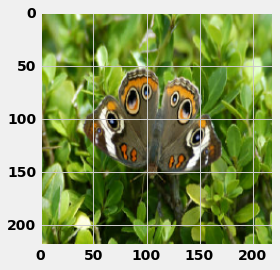

In [132]:
index = 15
img = plt.imshow(x_train[index])

In [133]:
print('The image label:', np.argmax(y_train[index]))

The image label: 3


In [134]:
# Get the classification of the image
classification = ['Danaus plexippus',
                  'Heliconius charitonius',
                  'Heliconius erato',
                  'Junonia coenia',
                  'Lycaena phlaeas',
                  'Nymphalis antiopa',
                  'Papilio cresphontes',
                  'Pieris rapae',
                  'Vanessa atalanta',
                  'Vanessa cardui']

In [135]:
print('Image class is:', classification[np.argmax(y_train[index])])

Image class is: Junonia coenia


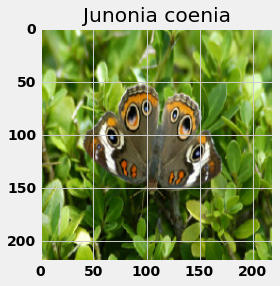

In [136]:
# Check an image and label together
index = 15
plt.figure()
plt.title(classification[np.argmax(y_train[index])])
img = plt.imshow(x_train[index])

### Preprocess images with ImageDataGenerator

In [137]:
# Paths to training and testing directories
train_path = "..\\butterfly_images\\train\\"
test_path = "..\\butterfly_images\\test\\"

In [138]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.15,
                               height_shift_range=0.15,
                               zoom_range=0.1,
                               shear_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [139]:
image_gen.flow_from_directory(train_path), image_gen.flow_from_directory(test_path)

Found 665 images belonging to 10 classes.
Found 167 images belonging to 10 classes.


(<keras.preprocessing.image.DirectoryIterator at 0x1807326de20>,
 <keras.preprocessing.image.DirectoryIterator at 0x1807326da30>)

In [140]:
batch_size=64

In [141]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=img_shape[:2], # First two dimensions (220, 220)
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical') 

Found 665 images belonging to 10 classes.


In [142]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=img_shape[:2], # First two dimensions (220, 220)
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False) 

Found 167 images belonging to 10 classes.


In [143]:
test_image_gen.class_indices

{'Danaus_plexippus': 0,
 'Heliconius_charitonius': 1,
 'Heliconius_erato': 2,
 'Junonia_coenia': 3,
 'Lycaena_phlaeas': 4,
 'Nymphalis_antiopa': 5,
 'Papilio_cresphontes': 6,
 'Pieris_rapae': 7,
 'Vanessa_atalanta': 8,
 'Vanessa_cardui': 9}

In [144]:
img_array = x_train[202]

Text(0.5, 0.98, 'Transformation Examples')

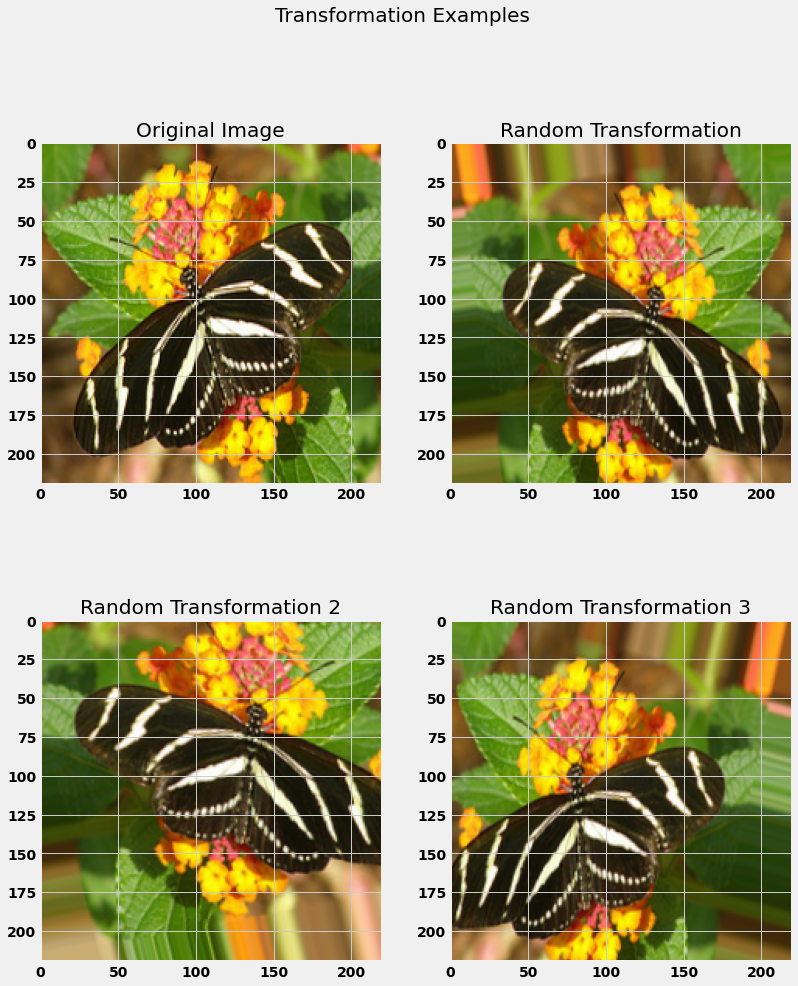

In [145]:
fig,ax=plt.subplots(2,2)
fig.set_size_inches(12,15)


ax[0,0].imshow(img_array)
ax[0,0].set_title('Original Image')
ax[0,1].imshow(image_gen.random_transform(img_array))
ax[0,1].set_title('Random Transformation')
ax[1,0].imshow(image_gen.random_transform(img_array))
ax[1,0].set_title('Random Transformation 2')
ax[1,1].imshow(image_gen.random_transform(img_array))
ax[1,1].set_title('Random Transformation 3')


fig.suptitle('Transformation Examples', fontsize=20)

### Early Stopping

In [146]:
early_stop = EarlyStopping(monitor='val_loss',patience=4)

### Create a model

In [278]:
model = Sequential()

# First layer needs an input shape, 16 filters
model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2))) # Two-by-two pixel filter gets max element from the feature maps

# creating more filters as we get deeper into the network
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=img_shape, activation='relu')) 
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Flattening layer
model.add(Flatten()) # Reduce the dimensionality to a linear array

# Layer with 1024 neurons, 50% dropout
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))

# Layer with 512 neurons, 25% dropout
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.15))

# Layer with 256 neurons, 15% dropout
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.15))

# Layer with 128 neurons, 50% dropout
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.10))

# Layer with 10 neurons
# Softmax assigns decimal probabilities to each class
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [279]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 216, 216, 32)      2432      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 106, 106, 64)      18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 51, 51, 128)       73856     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 23, 23, 128)     

In [280]:
results = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=50,
                    callbacks=early_stop,
                    validation_split=0.2)

Epoch 1/50
9/9 [==============================] - 14s 2s/step - loss: 2.3042 - accuracy: 0.1090 - val_loss: 2.2838 - val_accuracy: 0.0902
Epoch 2/50
9/9 [==============================] - 13s 1s/step - loss: 2.2803 - accuracy: 0.1259 - val_loss: 2.2354 - val_accuracy: 0.1203
Epoch 3/50
9/9 [==============================] - 14s 2s/step - loss: 2.1733 - accuracy: 0.1259 - val_loss: 2.0116 - val_accuracy: 0.1729
Epoch 4/50
9/9 [==============================] - 14s 2s/step - loss: 1.9974 - accuracy: 0.2218 - val_loss: 1.9237 - val_accuracy: 0.2707
Epoch 5/50
9/9 [==============================] - 14s 2s/step - loss: 1.9890 - accuracy: 0.2406 - val_loss: 1.9201 - val_accuracy: 0.3233
Epoch 6/50
9/9 [==============================] - 14s 2s/step - loss: 1.8471 - accuracy: 0.2914 - val_loss: 1.6246 - val_accuracy: 0.3910
Epoch 7/50
9/9 [==============================] - 14s 2s/step - loss: 1.5859 - accuracy: 0.4079 - val_loss: 1.4804 - val_accuracy: 0.4436
Epoch 8/50
9/9 [==================

### Evaluate Model

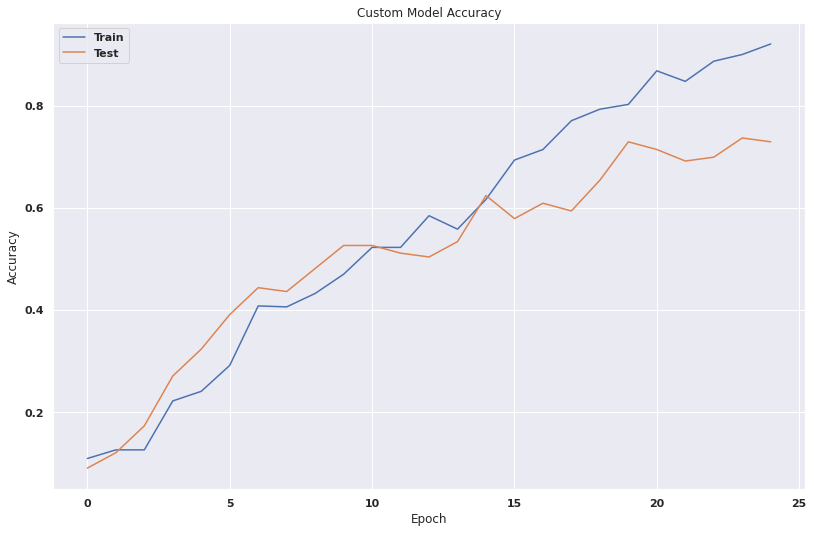

In [335]:
plt.figure(figsize=(12,8))
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Custom Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

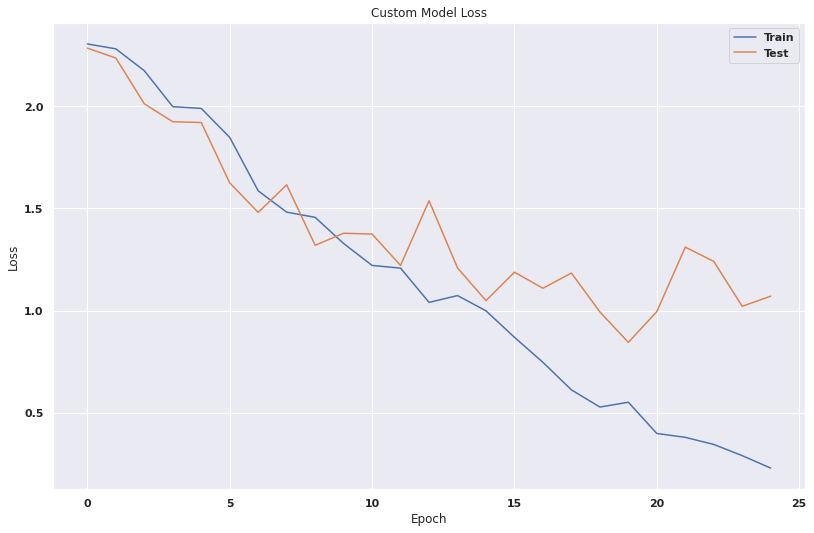

In [336]:
plt.figure(figsize=(12,8))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom Model Loss')
plt.legend(['Train','Test'])
plt.show()

In [283]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 131ms/step - loss: 1.2099 - accuracy: 0.7186


[1.2099441289901733, 0.71856290102005]

### Custom model on image generator

In [284]:
test_image_gen.reset()

In [285]:
cust_model = Sequential()

# First layer needs an input shape, 16 filters
cust_model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=img_shape, activation='relu'))
cust_model.add(MaxPool2D(pool_size=(2,2))) # Two-by-two pixel filter gets max element from the feature maps

# creating more filters as we get deeper into the network
cust_model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=img_shape, activation='relu')) 
cust_model.add(MaxPool2D(pool_size=(2,2)))

cust_model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
cust_model.add(MaxPool2D(pool_size=(2,2)))

cust_model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
cust_model.add(MaxPool2D(pool_size=(2,2)))

cust_model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
cust_model.add(MaxPool2D(pool_size=(2,2)))

# Flattening layer
cust_model.add(Flatten()) # Reduce the dimensionality to a linear array

# Layer with 1024 neurons, 50% dropout
cust_model.add(Dense(1024,activation='relu'))
cust_model.add(Dropout(0.5))

# Layer with 512 neurons, 25% dropout
cust_model.add(Dense(512,activation='relu'))
cust_model.add(Dropout(0.15))

# Layer with 256 neurons, 15% dropout
cust_model.add(Dense(256,activation='relu'))
cust_model.add(Dropout(0.15))

# Layer with 128 neurons, 50% dropout
cust_model.add(Dense(128,activation='relu'))
cust_model.add(Dropout(0.10))

# Layer with 10 neurons
# Softmax assigns decimal probabilities to each class
cust_model.add(Dense(10, activation='softmax'))

cust_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [286]:
cust_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 216, 216, 32)      2432      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 106, 106, 64)      18496     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 51, 51, 128)       73856     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 23, 23, 128)     

In [287]:
cust_results = cust_model.fit(train_image_gen,
                    validation_data=test_image_gen,
                    batch_size=batch_size,
                    epochs=50,
                    callbacks=early_stop)

Epoch 1/50
11/11 [==============================] - 24s 2s/step - loss: 4.6483 - accuracy: 0.1278 - val_loss: 2.2666 - val_accuracy: 0.1916
Epoch 2/50
11/11 [==============================] - 23s 2s/step - loss: 2.2814 - accuracy: 0.1308 - val_loss: 2.2345 - val_accuracy: 0.2275
Epoch 3/50
11/11 [==============================] - 23s 2s/step - loss: 2.2174 - accuracy: 0.1759 - val_loss: 2.0472 - val_accuracy: 0.2455
Epoch 4/50
11/11 [==============================] - 23s 2s/step - loss: 2.0405 - accuracy: 0.2376 - val_loss: 1.8995 - val_accuracy: 0.2874
Epoch 5/50
11/11 [==============================] - 22s 2s/step - loss: 1.8905 - accuracy: 0.2707 - val_loss: 1.6341 - val_accuracy: 0.3593
Epoch 6/50
11/11 [==============================] - 22s 2s/step - loss: 1.6831 - accuracy: 0.3368 - val_loss: 1.6211 - val_accuracy: 0.4311
Epoch 7/50
11/11 [==============================] - 23s 2s/step - loss: 1.6890 - accuracy: 0.3203 - val_loss: 1.4253 - val_accuracy: 0.4671
Epoch 8/50
11/11 [==

### Evaluate custom model on image generator

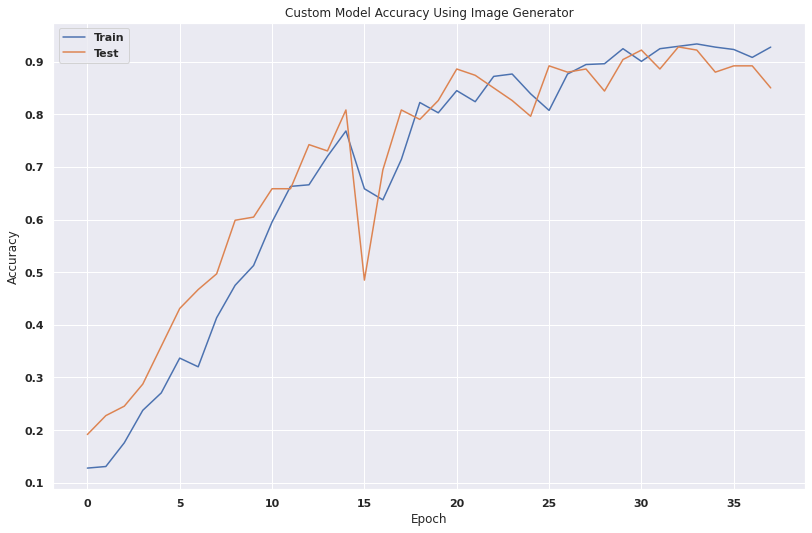

In [337]:
plt.figure(figsize=(12,8))
plt.plot(cust_results.history['accuracy'])
plt.plot(cust_results.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Custom Model Accuracy Using Image Generator')
plt.legend(['Train','Test'])
plt.show()

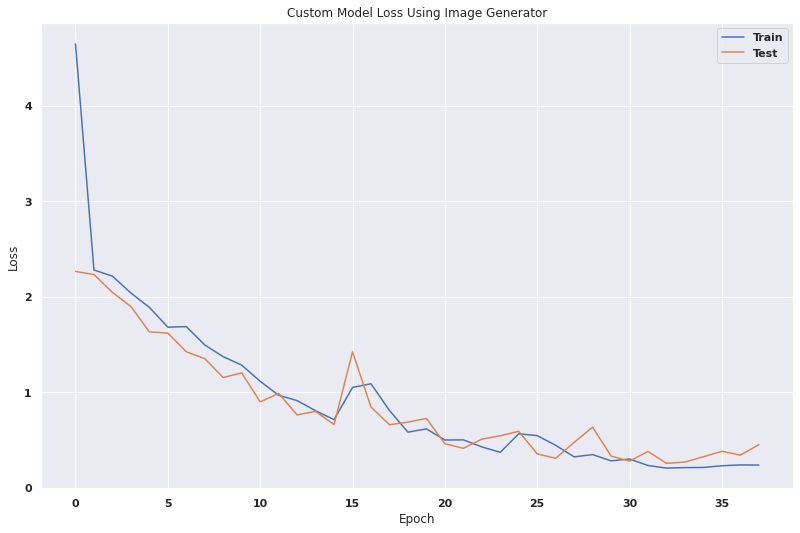

In [338]:
plt.figure(figsize=(12,8))
plt.plot(cust_results.history['loss'])
plt.plot(cust_results.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom Model Loss Using Image Generator')
plt.legend(['Train','Test'])
plt.show()

In [290]:
cust_model.evaluate(test_image_gen)

3/3 [==============================] - 3s 859ms/step - loss: 0.4382 - accuracy: 0.8683


[0.43815311789512634, 0.8682634830474854]

### DenseNet121

In [147]:
from tensorflow.keras.applications import DenseNet121

In [148]:
# Using pre-trained imagenet weights
dense_mod = DenseNet121(weights='imagenet', input_shape=img_shape, include_top=False)

In [149]:
# Make the layers that we loaded non-trainable
# We are using the model as a feature extractor
for layer in dense_mod.layers:
    layer.trainable = False

In [150]:
x = Flatten()(dense_mod.output)
outputs = Dense(len(y[1]), activation='softmax')(x) # y[1] is categories (10)

In [151]:
dense_model = Model(inputs=dense_mod.input, outputs=outputs)

dense_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 226, 226, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 110, 110, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 110, 110, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [152]:
dense_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [153]:
dense_history = dense_model.fit(x_train,
                                y_train,
                                batch_size=batch_size,
                                epochs=10,
                                callbacks=early_stop,
                                validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 30s 3s/step - loss: 7.0252 - accuracy: 0.3848 - val_loss: 1.4567 - val_accuracy: 0.7872
Epoch 2/10
9/9 [==============================] - 25s 3s/step - loss: 0.7022 - accuracy: 0.8670 - val_loss: 0.2969 - val_accuracy: 0.9291
Epoch 3/10
9/9 [==============================] - 25s 3s/step - loss: 0.1250 - accuracy: 0.9805 - val_loss: 0.1406 - val_accuracy: 0.9716
Epoch 4/10
9/9 [==============================] - 25s 3s/step - loss: 0.0544 - accuracy: 0.9911 - val_loss: 0.0467 - val_accuracy: 0.9929
Epoch 5/10
9/9 [==============================] - 25s 3s/step - loss: 0.0054 - accuracy: 0.9965 - val_loss: 0.0389 - val_accuracy: 0.9929
Epoch 6/10
9/9 [==============================] - 25s 3s/step - loss: 6.7365e-05 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9929
Epoch 7/10
9/9 [==============================] - 25s 3s/step - loss: 1.0319e-04 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 0.9929
Epoch 8/10
9/9 [==========

### Evaluate the DenseNet121 model

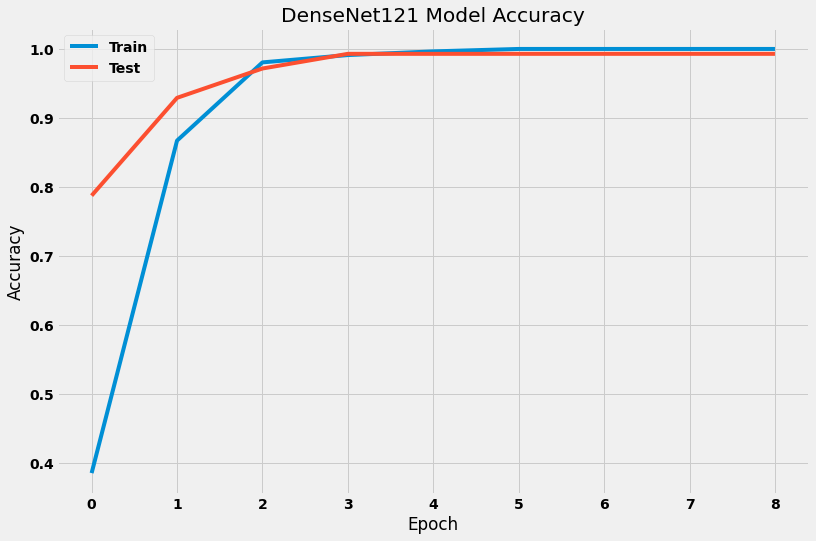

In [154]:
plt.figure(figsize=(12,8))
plt.plot(dense_history.history['accuracy'])
plt.plot(dense_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

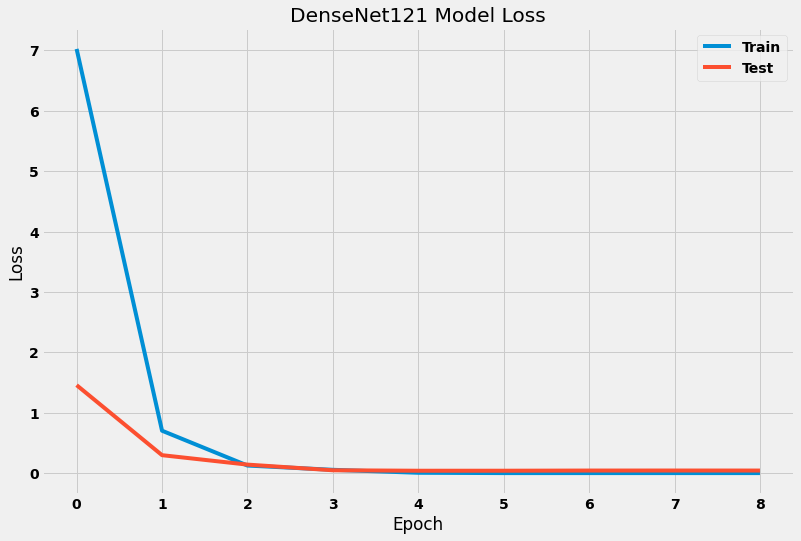

In [155]:
plt.figure(figsize=(12,8))
plt.plot(dense_history.history['loss'])
plt.plot(dense_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DenseNet121 Model Loss')
plt.legend(['Train','Test'])
plt.show()

In [156]:
dense_model.evaluate(x_test, y_test)

6/6 [==============================] - 7s 1s/step - loss: 0.0568 - accuracy: 0.9831


[0.056834496557712555, 0.9830508232116699]

### DenseNet121 model on image generator

In [38]:
test_image_gen.reset()

In [39]:
dense_mod_on_gen = DenseNet121(weights='imagenet', input_shape=img_shape, include_top=False)

In [40]:
# Make the layers that we loaded non-trainable
# We are using the model as a feature extractor
for layer in dense_mod_on_gen.layers:
    layer.trainable = False

In [41]:
x = Flatten()(dense_mod_on_gen.output)
outputs = Dense(len(y[1]), activation='softmax')(x) # y[1] is categories (10)

In [42]:
dense_mod_on_gen = Model(inputs=dense_mod_on_gen.input, outputs=outputs)

dense_mod_on_gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 226, 226, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 110, 110, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 110, 110, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [43]:
dense_mod_on_gen.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [44]:
dense_mod_on_gen_history = dense_mod_on_gen.fit(train_image_gen,
                    validation_data=test_image_gen,
                    batch_size=batch_size,
                    epochs=50,
                    callbacks=early_stop)

Epoch 1/50
11/11 [==============================] - 37s 3s/step - loss: 48.3549 - accuracy: 0.2466 - val_loss: 34.1323 - val_accuracy: 0.3353
Epoch 2/50
11/11 [==============================] - 33s 3s/step - loss: 17.0021 - accuracy: 0.5308 - val_loss: 14.4999 - val_accuracy: 0.6347
Epoch 3/50
11/11 [==============================] - 32s 3s/step - loss: 6.1299 - accuracy: 0.7263 - val_loss: 5.9165 - val_accuracy: 0.7784
Epoch 4/50
11/11 [==============================] - 32s 3s/step - loss: 3.0666 - accuracy: 0.8421 - val_loss: 4.0639 - val_accuracy: 0.8024
Epoch 5/50
11/11 [==============================] - 32s 3s/step - loss: 1.8638 - accuracy: 0.8887 - val_loss: 5.2053 - val_accuracy: 0.8263
Epoch 6/50
11/11 [==============================] - 32s 3s/step - loss: 1.0310 - accuracy: 0.9218 - val_loss: 6.0740 - val_accuracy: 0.7784
Epoch 7/50
11/11 [==============================] - 33s 3s/step - loss: 0.7646 - accuracy: 0.9323 - val_loss: 2.9678 - val_accuracy: 0.8383
Epoch 8/50
11/11

### Evaluate DenseNet121 on image generator

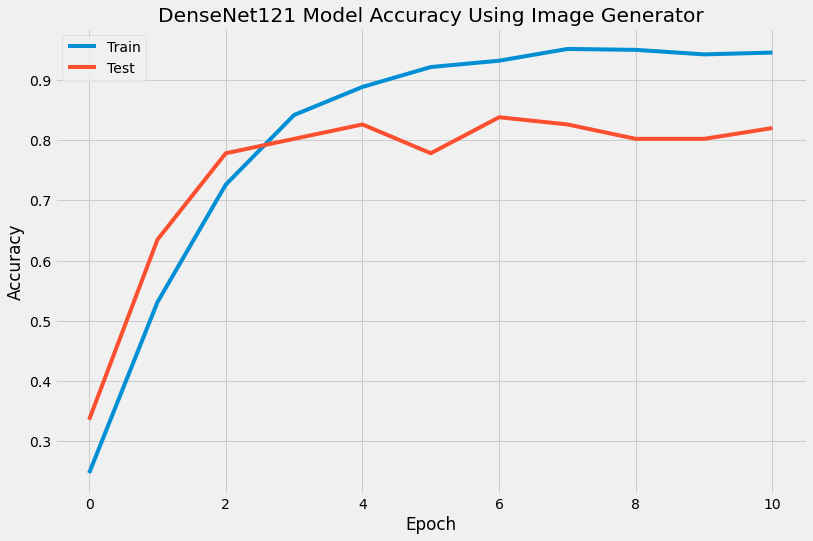

In [160]:
plt.figure(figsize=(12,8))
plt.plot(dense_mod_on_gen_history.history['accuracy'])
plt.plot(dense_mod_on_gen_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy Using Image Generator')
plt.legend(['Train','Test'])
plt.show()

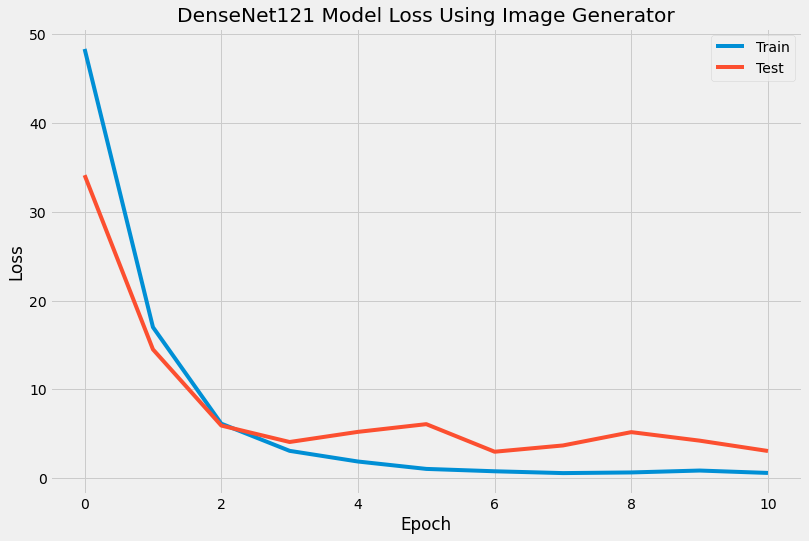

In [161]:
plt.figure(figsize=(12,8))
plt.plot(dense_mod_on_gen_history.history['loss'])
plt.plot(dense_mod_on_gen_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DenseNet121 Model Loss Using Image Generator')
plt.legend(['Train','Test'])
plt.show()

In [162]:
dense_mod_on_gen.evaluate(test_image_gen)

3/3 [==============================] - 7s 2s/step - loss: 3.6222 - accuracy: 0.8024


[3.622227430343628, 0.802395224571228]

### ResNet50V2

In [311]:
from tensorflow.keras.applications import ResNet50V2

In [312]:
# Using pre-trained imagenet weights
res_mod = ResNet50V2(weights='imagenet', input_shape=img_shape, include_top=False)

In [313]:
# Make the layers that we loaded non-trainable
# We are using the model as a feature extractor
for layer in res_mod.layers:
    layer.trainable = False

In [314]:
x = Flatten()(res_mod.output)
outputs = Dense(10, activation='softmax')(x)

In [315]:
res_mod = Model(inputs=res_mod.input, outputs=outputs)

res_mod.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [316]:
res_mod.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [317]:
res_history = res_mod.fit(x_train, 
                          y_train,
                          batch_size=batch_size,
                          epochs=25,
                          callbacks=early_stop,
                          validation_split=0.2)

Epoch 1/25
9/9 [==============================] - 20s 2s/step - loss: 4.7495 - accuracy: 0.6071 - val_loss: 0.3567 - val_accuracy: 0.9398
Epoch 2/25
9/9 [==============================] - 18s 2s/step - loss: 0.4730 - accuracy: 0.9605 - val_loss: 0.8105 - val_accuracy: 0.9248
Epoch 3/25
9/9 [==============================] - 18s 2s/step - loss: 0.0378 - accuracy: 0.9962 - val_loss: 0.2100 - val_accuracy: 0.9699
Epoch 4/25
9/9 [==============================] - 18s 2s/step - loss: 0.1127 - accuracy: 0.9887 - val_loss: 0.1218 - val_accuracy: 0.9850
Epoch 5/25
9/9 [==============================] - 18s 2s/step - loss: 2.2981e-06 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9774
Epoch 6/25
9/9 [==============================] - 18s 2s/step - loss: 1.0773e-06 - accuracy: 1.0000 - val_loss: 0.1809 - val_accuracy: 0.9699
Epoch 7/25
9/9 [==============================] - 18s 2s/step - loss: 4.4454e-05 - accuracy: 1.0000 - val_loss: 0.2673 - val_accuracy: 0.9699
Epoch 8/25
9/9 [======

### Evaluate ResNet50V2

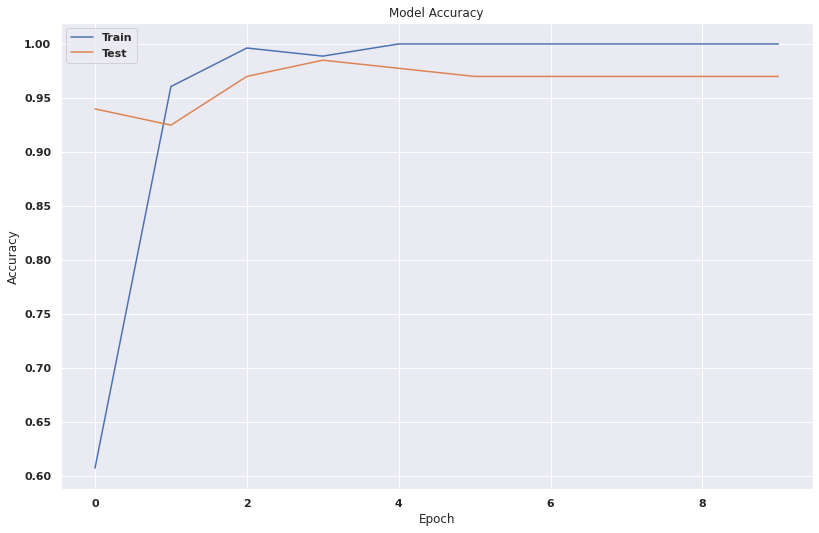

In [318]:
plt.figure(figsize=(12,8))
plt.plot(res_history.history['accuracy'])
plt.plot(res_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

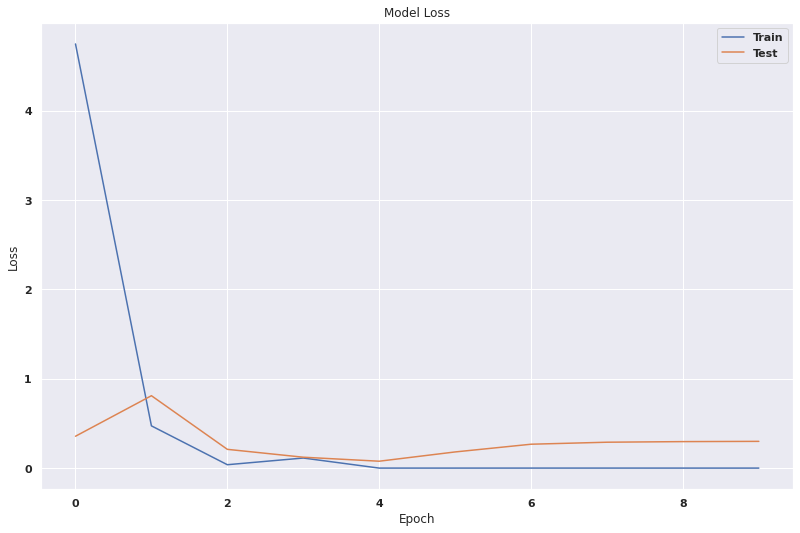

In [319]:
plt.figure(figsize=(12,8))
plt.plot(res_history.history['loss'])
plt.plot(res_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()

In [320]:
res_mod.evaluate(x_test, y_test)

6/6 [==============================] - 5s 771ms/step - loss: 1.4385 - accuracy: 0.9102


[1.4385085105895996, 0.910179615020752]

### ResNet50V2 model on image generator

In [321]:
test_image_gen.reset()

In [322]:
# Using pre-trained imagenet weights
res_mod_on_gen = ResNet50V2(weights='imagenet', input_shape=img_shape, include_top=False)

In [323]:
# Make the layers that we loaded non-trainable
# We are using the model as a feature extractor
for layer in res_mod_on_gen.layers:
    layer.trainable = False

In [324]:
x = Flatten()(res_mod_on_gen.output)
outputs = Dense(10, activation='softmax')(x)

In [325]:
res_mod_on_gen = Model(inputs=res_mod_on_gen.input, outputs=outputs)

res_mod_on_gen.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [326]:
res_mod_on_gen.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [327]:
res_mod_on_gen_history = res_mod_on_gen.fit(train_image_gen,
                          validation_data=test_image_gen,
                          batch_size=batch_size,
                          epochs=25,
                          callbacks=early_stop)

Epoch 1/25
11/11 [==============================] - 30s 3s/step - loss: 2411.1035 - accuracy: 0.1579 - val_loss: 2014.4929 - val_accuracy: 0.1317
Epoch 2/25
11/11 [==============================] - 27s 2s/step - loss: 1549.7440 - accuracy: 0.2105 - val_loss: 1452.5535 - val_accuracy: 0.1856
Epoch 3/25
11/11 [==============================] - 27s 2s/step - loss: 648.9533 - accuracy: 0.3534 - val_loss: 504.5269 - val_accuracy: 0.3473
Epoch 4/25
11/11 [==============================] - 27s 2s/step - loss: 361.4808 - accuracy: 0.4541 - val_loss: 509.9696 - val_accuracy: 0.4192
Epoch 5/25
11/11 [==============================] - 27s 2s/step - loss: 274.7979 - accuracy: 0.5278 - val_loss: 332.9433 - val_accuracy: 0.5030
Epoch 6/25
11/11 [==============================] - 27s 2s/step - loss: 193.6639 - accuracy: 0.5910 - val_loss: 195.6787 - val_accuracy: 0.5150
Epoch 7/25
11/11 [==============================] - 27s 2s/step - loss: 111.4259 - accuracy: 0.6586 - val_loss: 225.3465 - val_accur

### Evaluate ResNet50V2 on image generator

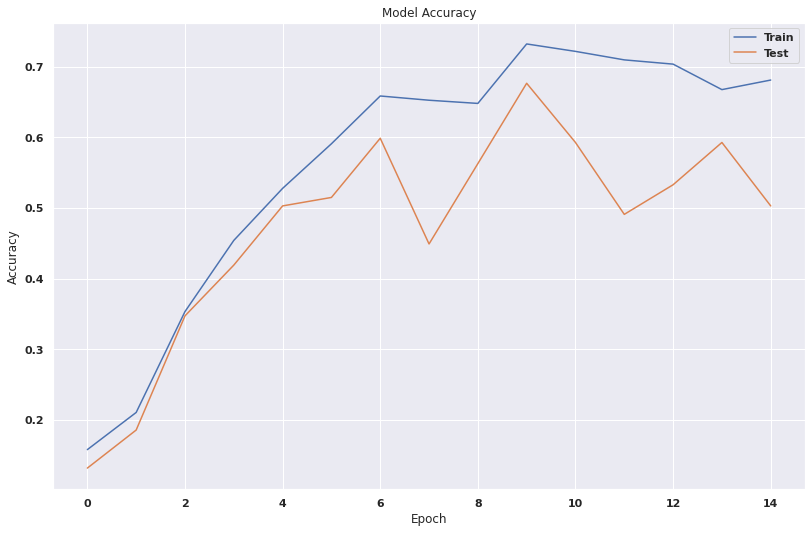

In [328]:
plt.figure(figsize=(12,8))
plt.plot(res_mod_on_gen_history.history['accuracy'])
plt.plot(res_mod_on_gen_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

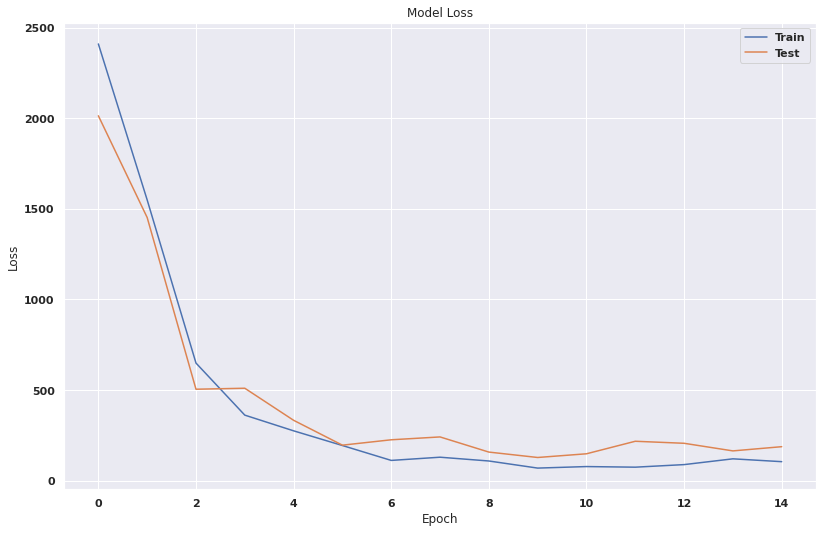

In [329]:
plt.figure(figsize=(12,8))
plt.plot(res_mod_on_gen_history.history['loss'])
plt.plot(res_mod_on_gen_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()

In [330]:
res_mod_on_gen.evaluate(test_image_gen)

3/3 [==============================] - 6s 1s/step - loss: 170.0027 - accuracy: 0.4910


[170.00267028808594, 0.4910179674625397]

### Compare the models

In [398]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 1s 137ms/step - loss: 1.2099 - accuracy: 0.7186


[1.2099441289901733, 0.71856290102005]

In [399]:
cust_model.evaluate(test_image_gen)

3/3 [==============================] - 3s 870ms/step - loss: 0.4690 - accuracy: 0.8563


[0.469041109085083, 0.85628741979599]

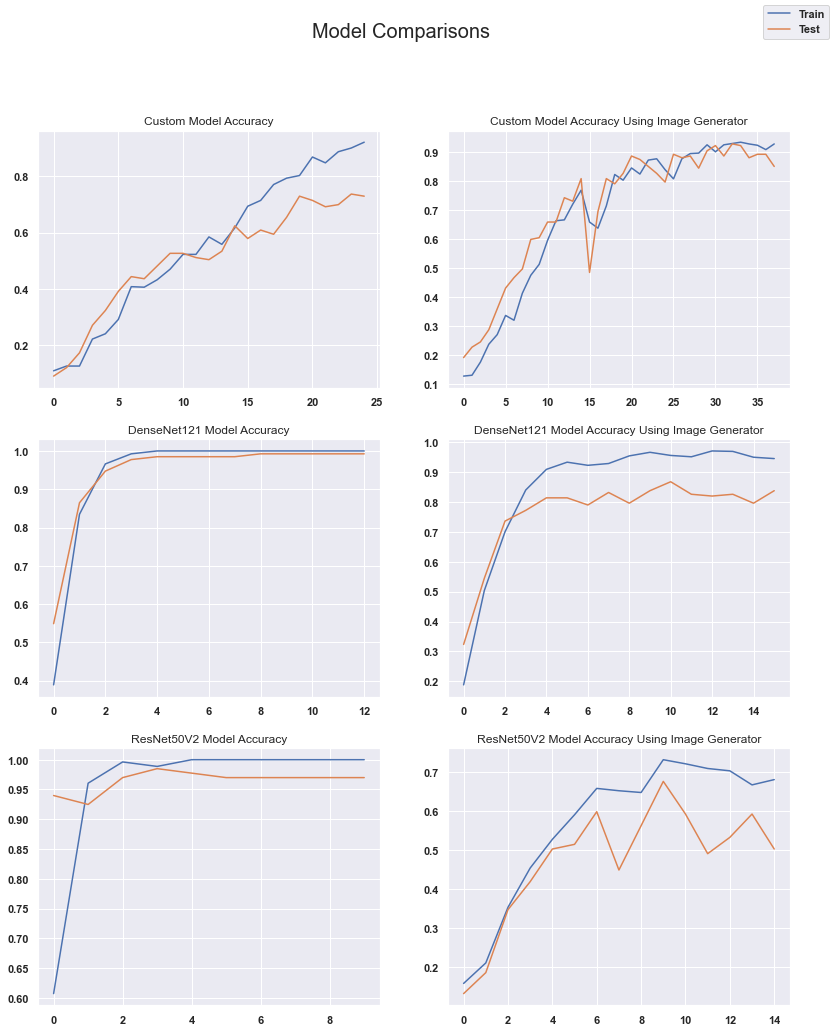

In [406]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(12,15)

ax[0,0].plot(results.history['accuracy'])
ax[0,0].plot(results.history['val_accuracy'])
ax[0,0].set_title('Custom Model Accuracy')

ax[0,1].plot(cust_results.history['accuracy'])
ax[0,1].plot(cust_results.history['val_accuracy'])
ax[0,1].set_title('Custom Model Accuracy Using Image Generator')

ax[1,0].plot(dense_history.history['accuracy'])
ax[1,0].plot(dense_history.history['val_accuracy'])
ax[1,0].set_title('DenseNet121 Model Accuracy')

ax[1,1].plot(dense_mod_on_gen_history.history['accuracy'])
ax[1,1].plot(dense_mod_on_gen_history.history['val_accuracy'])
ax[1,1].set_title('DenseNet121 Model Accuracy Using Image Generator')

ax[2,0].plot(res_history.history['accuracy'])
ax[2,0].plot(res_history.history['val_accuracy'])
ax[2,0].set_title('ResNet50V2 Model Accuracy')

ax[2,1].plot(res_mod_on_gen_history.history['accuracy'])
ax[2,1].plot(res_mod_on_gen_history.history['val_accuracy'])
ax[2,1].set_title('ResNet50V2 Model Accuracy Using Image Generator')

fig.suptitle('Model Comparisons', fontsize=20)
fig.legend(['Train','Test'])

### Classification report and Confusion matrix

**Two best models are Custom on generator set, and DenseNet121 on standard data**

In [378]:
test_image_gen.reset()

In [379]:
# Setting predictions > 0.5 turns them into booleans. NumPy reads these as 1's and 0's
# and can be used for a confusion matrix and classification report
pred = cust_model.predict(test_image_gen)
predictions = pred > 0.5
predictions

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [380]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [381]:
print(classification_report(test_image_gen.classes, np.argmax(predictions, axis=1), target_names=classification))

                        precision    recall  f1-score   support

      Danaus plexippus       0.74      0.88      0.80        16
Heliconius charitonius       1.00      0.58      0.73        19
      Heliconius erato       0.86      1.00      0.92        12
        Junonia coenia       0.88      0.78      0.82        18
       Lycaena phlaeas       0.76      0.94      0.84        17
     Nymphalis antiopa       0.95      0.95      0.95        20
   Papilio cresphontes       0.76      0.89      0.82        18
          Pieris rapae       0.85      1.00      0.92        11
      Vanessa atalanta       0.86      0.95      0.90        19
        Vanessa cardui       1.00      0.65      0.79        17

              accuracy                           0.85       167
             macro avg       0.86      0.86      0.85       167
          weighted avg       0.87      0.85      0.85       167



In [382]:
# Output clf_rerport as dict so we can use convert to dataframe for sns.heatmap
clf_report_dict = classification_report(test_image_gen.classes, np.argmax(predictions, axis=1), target_names=classification, output_dict=True)

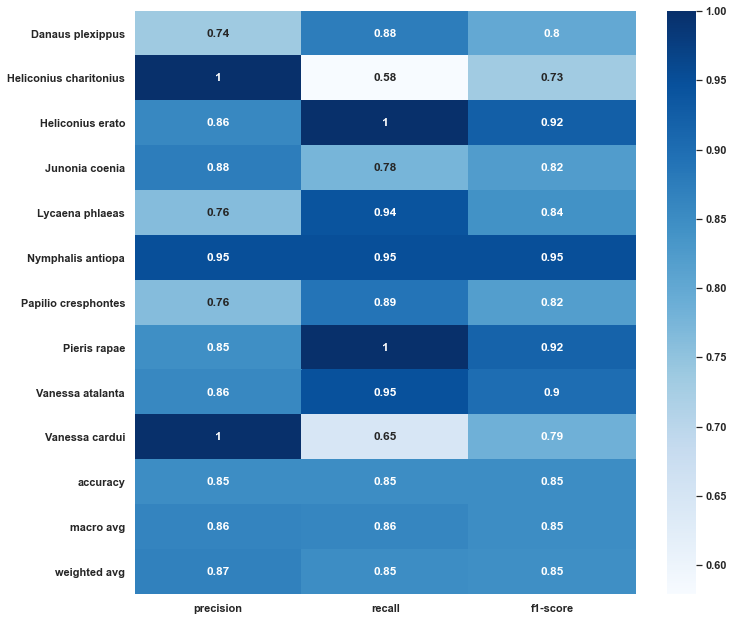

In [383]:
sns.heatmap(pd.DataFrame(clf_report_dict).iloc[:-1, :].T, annot=True, cmap="Blues")
sns.set(rc = {'figure.figsize':(10,10)})

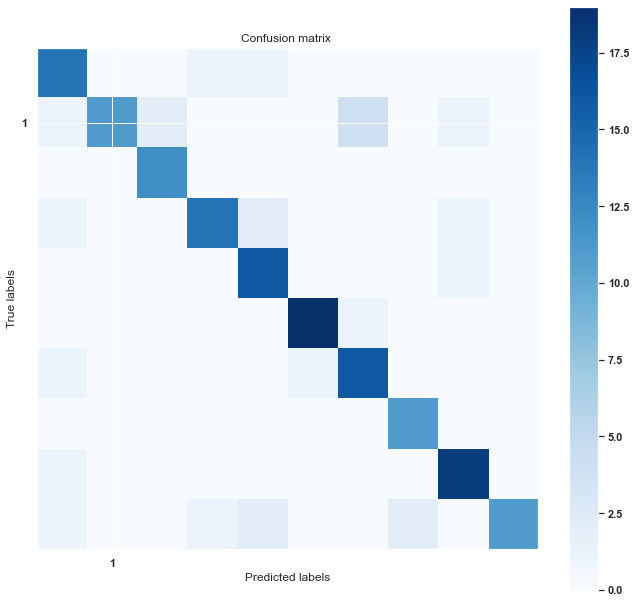

In [384]:
cm = confusion_matrix(test_image_gen.classes, np.argmax(predictions, axis=1))

plt.figure(figsize=(10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([1], [1])
plt.yticks([1], [1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

### DenseNet121 visualizations

In [408]:
Y_pred = dense_model.predict(x_test)

In [409]:
# y_pred will just be a single digit 0-9
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([7, 9, 3, 6, 1, 8, 9, 1, 3, 6, 9, 1, 3, 2, 0, 4, 3, 3, 9, 6, 5, 0,
       2, 6, 3, 6, 1, 5, 8, 4, 7, 4, 1, 6, 0, 6, 5, 6, 0, 0, 5, 7, 0, 9,
       5, 0, 9, 7, 5, 2, 8, 9, 4, 3, 6, 8, 8, 5, 6, 5, 9, 4, 8, 1, 8, 2,
       7, 8, 5, 5, 8, 0, 4, 3, 0, 9, 2, 9, 0, 0, 9, 6, 5, 2, 2, 5, 2, 0,
       0, 1, 6, 3, 9, 1, 3, 9, 4, 3, 6, 3, 9, 9, 7, 1, 0, 0, 9, 3, 7, 7,
       2, 4, 0, 9, 8, 9, 4, 5, 5, 8, 1, 0, 2, 1, 3, 6, 3, 8, 4, 1, 8, 7,
       0, 8, 9, 4, 8, 0, 6, 3, 8, 7, 8, 4, 8, 5, 6, 8, 5, 7, 0, 9, 8, 1,
       4, 4, 5, 9, 0, 8, 5, 7, 2, 7, 5, 9, 6], dtype=int64)

In [410]:
Y_true = []

for one_hot in y_test:
    Y_true.append(np.argmax(one_hot))

In [411]:
y_true = np.array(Y_true)

**DenseNet Confusion Matrix**

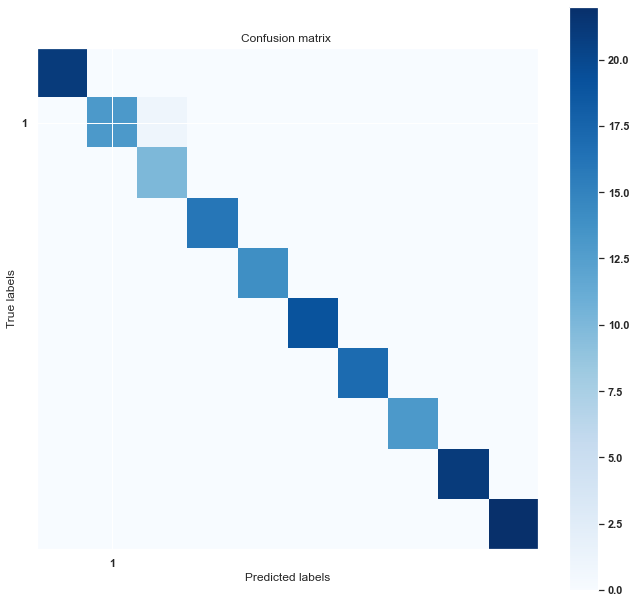

In [413]:
cm_dense = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm_dense, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([1], [1])
plt.yticks([1], [1])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**DenseNet Classification Report**

In [414]:
clf_report_dense = classification_report(y_true, y_pred, target_names=classification)
print(clf_report_dense)

                        precision    recall  f1-score   support

      Danaus plexippus       1.00      1.00      1.00        21
Heliconius charitonius       1.00      0.93      0.96        14
      Heliconius erato       0.91      1.00      0.95        10
        Junonia coenia       1.00      1.00      1.00        16
       Lycaena phlaeas       1.00      1.00      1.00        14
     Nymphalis antiopa       1.00      1.00      1.00        19
   Papilio cresphontes       1.00      1.00      1.00        17
          Pieris rapae       1.00      1.00      1.00        13
      Vanessa atalanta       1.00      1.00      1.00        21
        Vanessa cardui       1.00      1.00      1.00        22

              accuracy                           0.99       167
             macro avg       0.99      0.99      0.99       167
          weighted avg       0.99      0.99      0.99       167



In [415]:
clf_report_dense_dict = classification_report(y_true, y_pred, target_names=classification, output_dict=True)

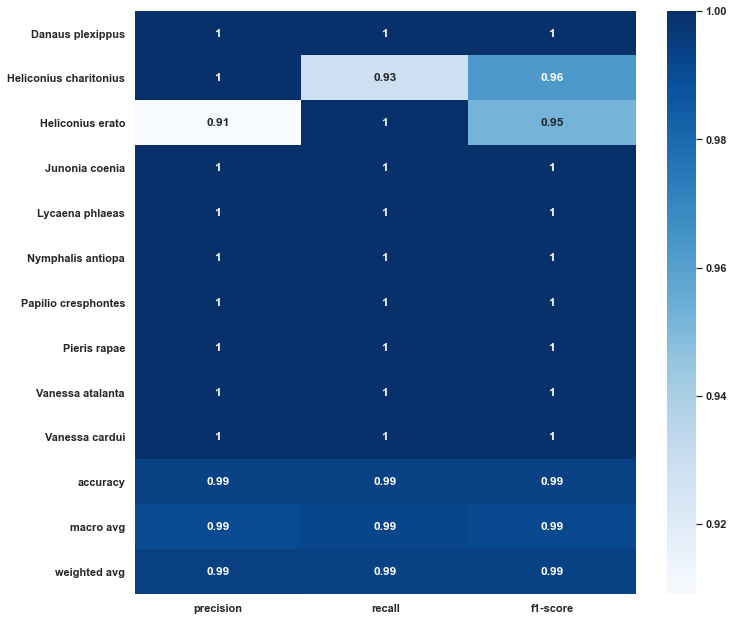

In [416]:
sns.heatmap(pd.DataFrame(clf_report_dense_dict).iloc[:-1, :].T, annot=True, cmap="Blues")
sns.set(rc = {'figure.figsize':(10,10)})

### Save the model

In [417]:
cust_model.save('custom_model.h5')

In [53]:
dense_model.save('dense_model.h5')

In [31]:
from tensorflow.keras.models import load_model

In [32]:
dense_model = load_model('dense_model.h5')

### Test the model

**Load a downloaded image**

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize

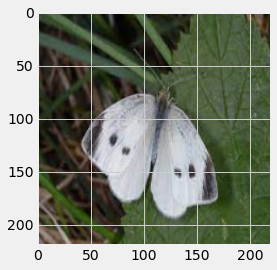

In [34]:
desktop = 'C:\\Users\\danny\\OneDrive\\Desktop\\'
img_path = desktop+'pieris2.jpg'
new_image = plt.imread(img_path)
# Resize the image
resized_image = resize(new_image, img_shape[:2])
img = plt.imshow(resized_image)

In [35]:
# single_prediction = cust_model.predict(np.array([resized_image]))
single_prediction_dense = dense_model.predict(np.array([resized_image]))

In [36]:
# single_prediction 
single_prediction_dense

array([[1.0566895e-31, 1.8858393e-22, 1.1916092e-22, 2.4204712e-27,
        2.6864134e-26, 4.9021485e-27, 6.7649963e-31, 1.0000000e+00,
        2.0020220e-28, 1.5024959e-22]], dtype=float32)

In [37]:
# test_image = image.load_img(img_path, target_size=(220,220))
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image,axis=0)
# result = cust_model.predict_generator(test_image)
# result_dense = dense_model.predict_generator(test_image)
# train_image_gen.class_indices

In [38]:
# np.argmax(single_prediction) 
np.argmax(single_prediction_dense)

7

In [39]:
# list_index = [0,1,2,3,4,5,6,7,8,9]
# x = single_prediction

# # Simple swapping function to sort the predictions least -> greatest
# for i in range(10):
#     for j in range(10):
#         if x[0][list_index[i]] > x[0][list_index[j]]:
#             temp = list_index[i]
#             list_index[i] = list_index[j]
#             list_index[j] = temp
            
# # labels in order
# print(list_index)

In [40]:
list_index_dense = [0,1,2,3,4,5,6,7,8,9]
x_dense = single_prediction_dense

# Simple swapping function to sort the predictions least -> greatest
for i in range(10):
    for j in range(10):
        if x_dense[0][list_index_dense[i]] > x_dense[0][list_index_dense[j]]:
            temp_dense = list_index_dense[i]
            list_index_dense[i] = list_index_dense[j]
            list_index_dense[j] = temp_dense
            
# labels in order
print(list_index_dense)

[7, 1, 9, 2, 4, 5, 3, 8, 6, 0]


In [41]:
# percentages = []
# for i in range(10):
#     percentages.append("{}: {}%".format(classification[list_index[i]],round(single_prediction[0][list_index[i]] * 100, 2)))

# percentages

In [42]:
percentages_dense = []
for i in range(10):
    percentages_dense.append("{}: {}%".format(classification[list_index_dense[i]],round(single_prediction_dense[0][list_index_dense[i]] * 100, 2)))

percentages_dense

['Pieris rapae: 100.0%',
 'Heliconius charitonius: 0.0%',
 'Vanessa cardui: 0.0%',
 'Heliconius erato: 0.0%',
 'Lycaena phlaeas: 0.0%',
 'Nymphalis antiopa: 0.0%',
 'Junonia coenia: 0.0%',
 'Vanessa atalanta: 0.0%',
 'Papilio cresphontes: 0.0%',
 'Danaus plexippus: 0.0%']

In [43]:
# percentage_only = []
# for i in range(10):
#     percent = round(single_prediction[0][list_index[i]] * 100, 2)
#     percentage_only.append(percent)
    
    
# type(percentage_only[1]), percentage_only

In [44]:
percentage_only_dense = []
for i in range(10):
    percent_dense = round(single_prediction_dense[0][list_index_dense[i]] * 100, 2)
    percentage_only_dense.append(percent_dense)
    
    
type(percentage_only_dense[1]), percentage_only_dense

(numpy.float64, [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [45]:
# fig,ax = plt.subplots()
# fig.set_size_inches(12,12)
# font = {'family': 'normal',
#         'weight': 'bold',
#         'size': 44}

# plt.rc('font', **font)
# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# # vals = ax.get_yticks()
# # ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# plt.ylim(0, 100)

# ax.bar(percentages, percentage_only)

# plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

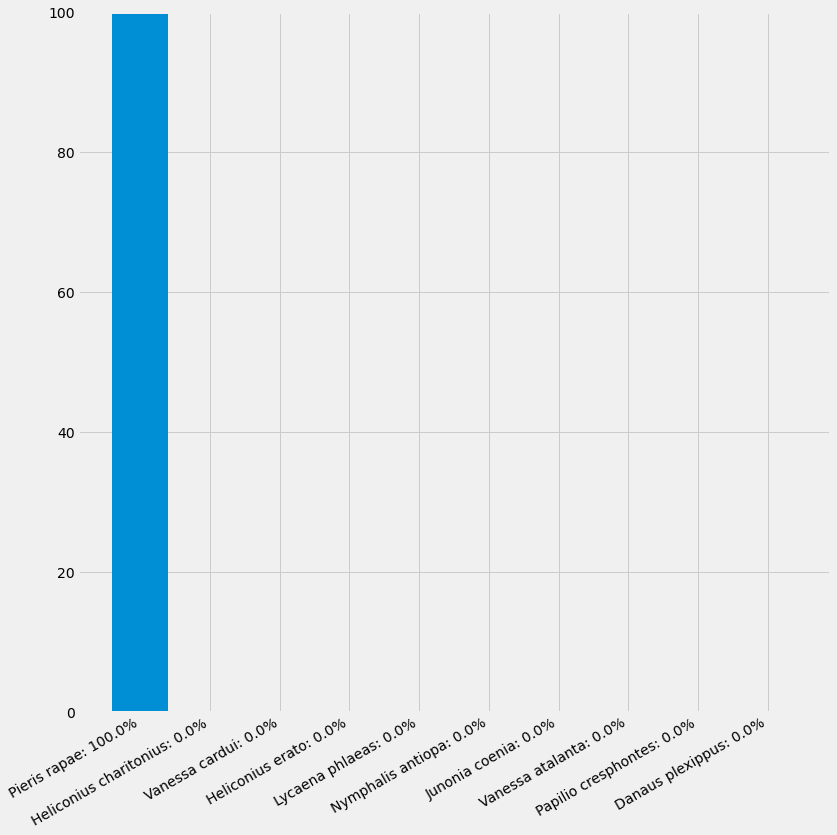

In [46]:
fig,ax = plt.subplots()
fig.set_size_inches(12,12)
font = {'family': 'normal',
        'weight': 'bold',
        'size': 44}

plt.rc('font', **font)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.ylim(0, 100)

ax.bar(percentages_dense, percentage_only_dense)

plt.show

### Data Visualization using PCA

In [158]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

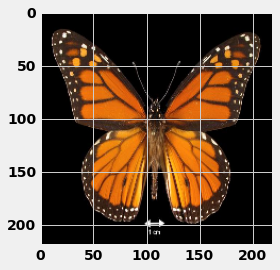

In [159]:
plt.imshow(images[1])

In [160]:
# Flatten the images (reshape dimensions from 3 to 1)
x_train.shape

(705, 220, 220, 3)

In [161]:
flattened = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
flattened

145200

In [162]:
x_train_flat = x_train.reshape(-1, flattened)

In [163]:
x_train_flat.shape

(705, 145200)

In [164]:
scaler = StandardScaler()
train_x = scaler.fit_transform(x_train_flat)
test_x = scaler.fit_transform(y_train)

In [165]:
print(classification[np.argmax(test_x[1])])

Danaus plexippus


In [166]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_flat)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])

principalDf = pd.concat([principalDf],axis = 1,ignore_index=True)

principalDf.columns = ['Principal Component 1', 'Principal Component 2'] 

<AxesSubplot:xlabel='Principal Component 1', ylabel='Principal Component 2'>

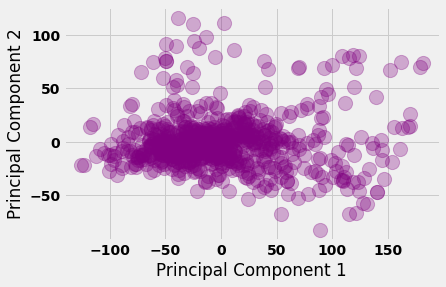

In [167]:
# give a list to the marker argument
sns.regplot(x=principalDf["Principal Component 1"], y=principalDf["Principal Component 2"],
            fit_reg=False, scatter_kws={"color":"purple","alpha":0.3,"s":200} )

In [168]:
dense_model.evaluate(x_test, y_test)

6/6 [==============================] - 7s 1s/step - loss: 0.0568 - accuracy: 0.9831


[0.056834496557712555, 0.9830508232116699]

C:\Users\danny\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


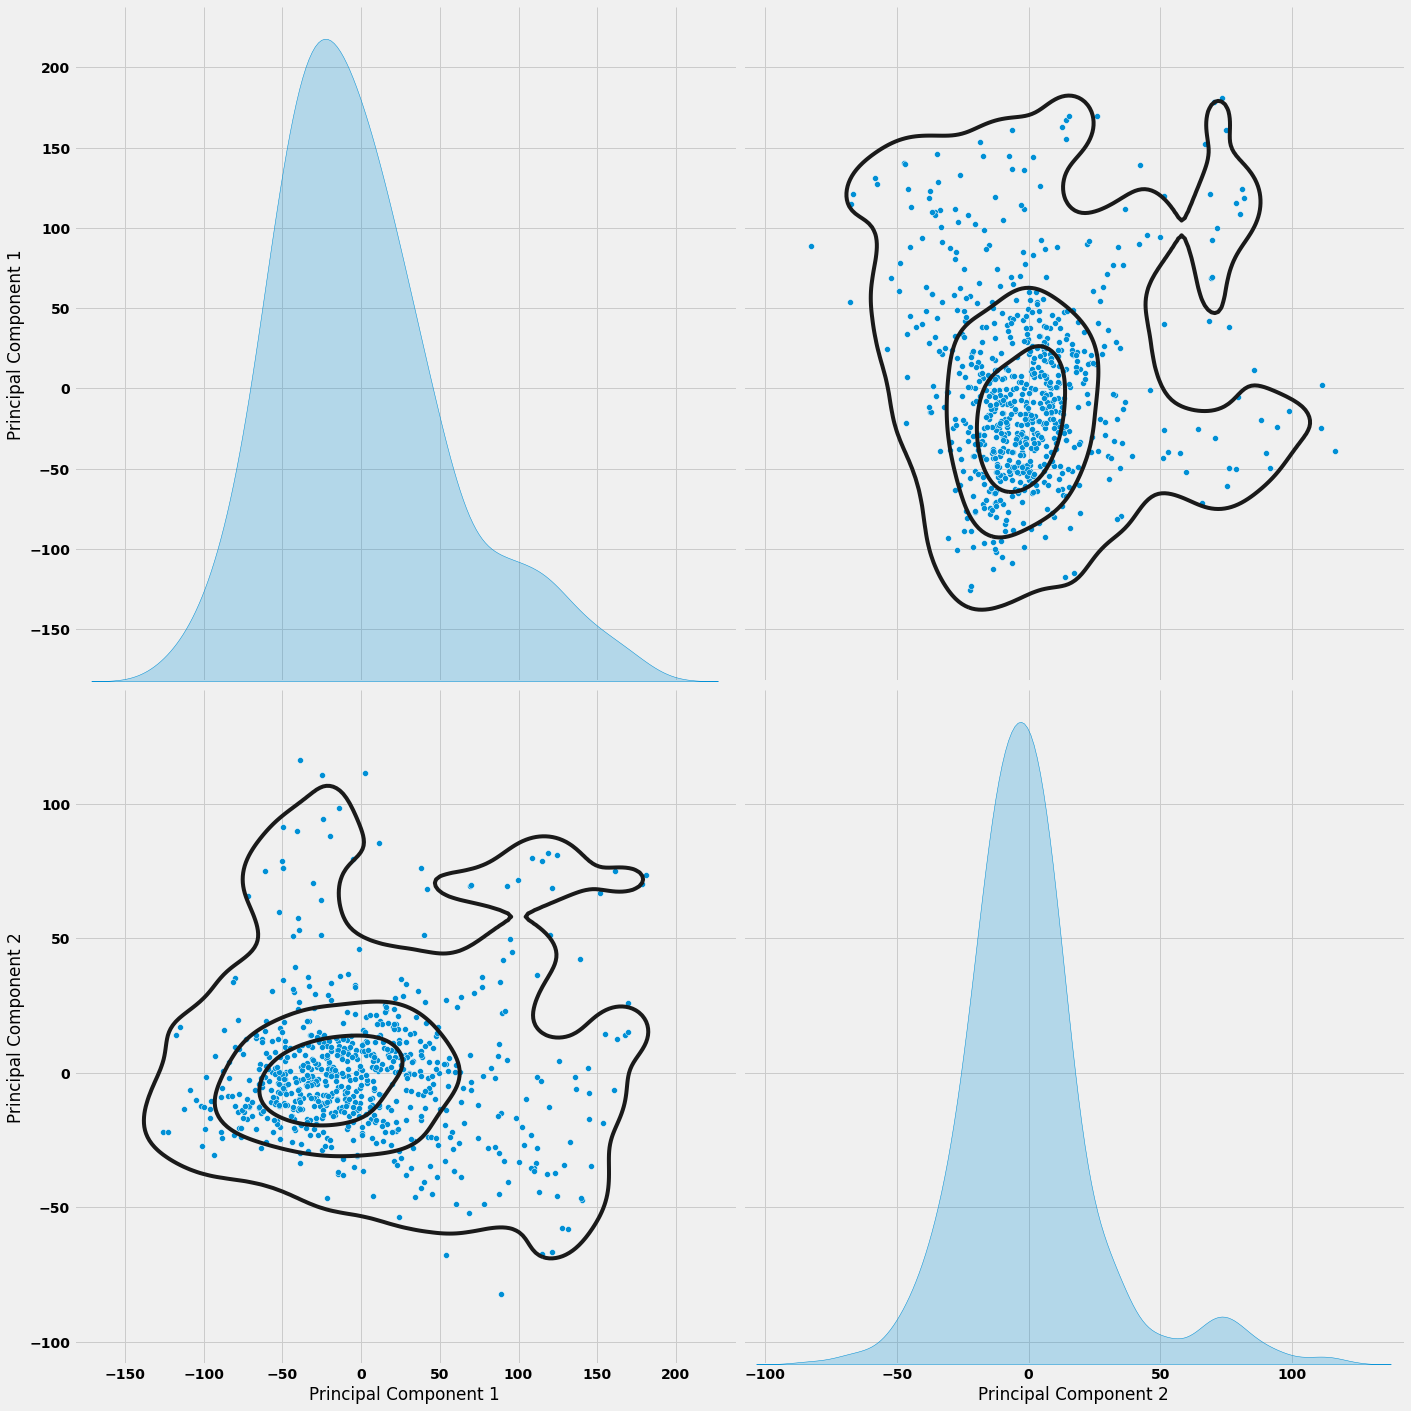

In [169]:
g = sns.pairplot(principalDf, size=10, diag_kind='kde')
g.map_offdiag(sns.kdeplot, levels=4, color='.1')